In [1]:
import numpy as np
from numpy import genfromtxt
from collections import Counter
from sklearn.cluster import KMeans
import pandas
import random
import math
from sklearn import svm
from scipy import linalg
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import plotly.plotly as py
import plotly.tools as tls
import pylab
from sklearn.preprocessing import normalize
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from scipy import stats
from sklearn.feature_selection import chi2
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import csgraph
import matplotlib.cm as cm
from sklearn.cluster import SpectralClustering
#from sklearn.model_selection import KFold, cross_val_score

## Loading in Data:

In [2]:
reviews = genfromtxt('review_matrix.csv', delimiter=',') # reviewer by movie (2482x818)
movies = pandas.read_csv('movie_data_cleaned_v2.csv') # all movies (3801 by 57)
review_to_movie = genfromtxt('review_to_imdb.csv', delimiter=',') # col in reviews -> row in movies
reviewer_to_gender = genfromtxt('review_to_gender.csv', delimiter=',')
reviewer_to_gender = map(lambda x: "m" if x==0 else "f", reviewer_to_gender) # row in reviews -> gender

In [3]:
num_reviewers = np.shape(reviews)[0]
num_movies = np.shape(reviews)[1]

## Minor Pre-Processing

There are a lot of reviewers that do not review many movies. Here, we set a minimum number of movies for a reviewer to be used in our classification. This number may change in later approaches where we combine review data from similar reviewers in the training set. 

In [4]:
min_num_reviews = 50 # do not include reviewers with < min_num_reviews reviews total
count_reviews = np.sum(np.absolute(reviews),axis=1)
good_reviewers = filter(lambda x: count_reviews[x] >= min_num_reviews, range(num_reviewers))
print("This leads to %d good reviewers." % np.shape(good_reviewers)[0])

### Use data structures below to make life easier ###
num_good_reviewers = len(good_reviewers)
good_reviews = reviews[good_reviewers,:]
good_reviewer_to_gender = [reviewer_to_gender[x] for x in good_reviewers]

This leads to 229 good reviewers.


In [5]:
good_movies = []
index = 0
for i in review_to_movie:
    good_movies.append(movies[int(i):int(i+1)].to_dict())
    for key in good_movies[index]:
        good_movies[index][key] = good_movies[index][key][i]
    index+=1
good_movies = pandas.DataFrame(good_movies)

In [6]:
binary_genders = [0]*len(good_reviewer_to_gender)
for i in range(len(good_reviewer_to_gender)):
    if (good_reviewer_to_gender[i]=="m"):
        binary_genders[i] = 1
    else:
        binary_genders[i] = 0

Here are all the important variables moving forward:
* num_good_reviewers, num_movies (specify dimensions of good_reviews matrix)
* good_reviews: reviewer by movie matrix (+1 is positive review, -1 is negative, 0 is no review)
* good_movies: movies that we have reviews for (cols here correspond to rows in good_reviews)
* good_reviewer_to_gender: reviewer idx to gender map

## Generally Useful Functions

In [7]:
### Returns something of the form [x,...,x] where x can be any object
def list_of_x(x, length):
    lst = np.empty((length,), dtype=np.object_)
    lst.fill(x)
    return np.frompyfunc(list,1,1)(lst)

def mean_matrix(v, n):
    v = np.matrix(v)
    mean = v.mean(axis=0)
    return np.repeat(mean,n,axis=0)

## Get Test/ Training Split

For now, lets do a 50/50 split. This ends up with a data-structure such that train[i] represents the columns (movies) in reviews that correspond to the testing set. The 50/50 split is done such that for each reviewer, half of their reviews are training and half are test. 

In [8]:
### Returns tuple with training and testing indices
### train: list of length num_good_reviewers
### train[i]: list of movie indices that are in training set for reviewer i
### Similar format for test
### Arguments: split - percentage of data going to train
def get_train_test(split):  
    train = list_of_x([],num_good_reviewers)
    test = list_of_x([],num_good_reviewers)
    for i in range(num_good_reviewers):
        valid_ind = filter(lambda x: not good_reviews[i][x] == 0, range(num_movies))
        train[i] = [valid_ind[j] for j in sorted(random.sample(xrange(len(valid_ind)), int(len(valid_ind)*split)))]
        test[i] = filter(lambda x: x not in train[i] and x in valid_ind, range(num_movies))
    return (train,test)
(train,test) = get_train_test(0.5)

## Useful Testing Functions

In [9]:
def get_confusion_matrix(pred, test):
    m = {"tp": 0, "tn": 0, "fp": 0, "fn": 0}
    for i in range(num_good_reviewers):
        for j in range(len(pred[i])):
            prediction = pred[i][j]
            actual = good_reviews[i][test[i][j]]
            if (prediction == actual):
                if (prediction == 1):
                    m["tp"]+=1
                else:
                    m["tn"]+=1
            else:
                if (prediction == 1):
                    m["fp"]+=1
                else:
                    m["fn"]+=1
    return m

def get_confusion_matrix_gender(pred, test, gender):
    m = {"tp": 0, "tn": 0, "fp": 0, "fn": 0}
    for i in range(num_good_reviewers):
        for j in range(len(pred[i])):
            prediction = pred[i][j]
            actual = good_reviews[i][test[i][j]]
            if (prediction == actual and good_reviewer_to_gender[i] == gender):
                if (prediction == 1):
                    m["tp"]+=1
                else:
                    m["tn"]+=1
            elif (good_reviewer_to_gender[i] == gender):
                if (prediction == 1):
                    m["fp"]+=1
                else:
                    m["fn"]+=1
    return m

In [10]:
def get_error(pred, test):
    conf_m = get_confusion_matrix(pred,test)
    return 1-(conf_m["tp"]+conf_m["tn"])/float(conf_m["tp"]+conf_m["tn"]+conf_m["fp"]+conf_m["fn"])

def get_error_gender(pred, test, gender):
    conf_m = get_confusion_matrix_gender(pred,test,gender)
    return 1-(conf_m["tp"]+conf_m["tn"])/float(conf_m["tp"]+conf_m["tn"]+conf_m["fp"]+conf_m["fn"])

In [11]:
def summarize_conf_m(pred,test):
    conf_m = get_confusion_matrix(pred,test)
    print("True Positive Rate: %0.2f" % (conf_m["tp"]/float(conf_m["tp"]+conf_m["fn"])))
    print("True Negative Rate: %0.2f" % (conf_m["tn"]/float(conf_m["tn"]+conf_m["fp"])))

def summarize_conf_m_gender(pred,test,gender):
    conf_m = get_confusion_matrix_gender(pred,test,gender)
    print("True Positive Rate: %0.2f" % (conf_m["tp"]/float(conf_m["tp"]+conf_m["fn"])))
    print("True Negative Rate: %0.2f" % (conf_m["tn"]/float(conf_m["tn"]+conf_m["fp"])))

In [12]:
def plotErrorByPerson(pred, test, filename):
    error = [0]*num_good_reviewers
    count_reviews = [0]*num_good_reviewers
    for i in range(num_good_reviewers):
        for j in range(len(pred[i])):
            if (not pred[i][j] == good_reviews[i][test[i][j]]):
                error[i]+=1
        error[i] = error[i]/float(len(pred[i]))
        count_reviews[i] = len(pred[i])
    count_reviews = np.argsort(count_reviews, axis=None)[::-1]
    errors_sorted = [0]*num_good_reviewers
    colors = ["r"]*num_good_reviewers
    for i in range(num_good_reviewers):
        errors_sorted[i] = error[count_reviews[i]]
        if (good_reviewer_to_gender[count_reviews[i]] == "m"):
            colors[i] = "b"
    plt.bar(range(num_good_reviewers), errors_sorted,color=colors)
    plt.xmin = 0
    plt.ylabel('Error Rate')
    plt.xlabel('High # Reviews to Low # Reviews')
    plt.title('Error Per Person (Female/Male Split)')
    pylab.savefig(filename+'.png')
    plt.show()

# Baseline Approach

* Set all testing to label of most common training label (does not use movies)

{'tn': 1903, 'fp': 4100, 'fn': 1557, 'tp': 6672}
{'tn': 777, 'fp': 1668, 'fn': 593, 'tp': 2590}
{'tn': 1126, 'fp': 2432, 'fn': 964, 'tp': 4082}
Error: 0.40
Female Error: 0.39
Male Error: 0.40
General Summary:
True Positive Rate: 0.81
True Negative Rate: 0.32
Male Summary:
True Positive Rate: 0.81
True Negative Rate: 0.32
Female Summary:
True Positive Rate: 0.81
True Negative Rate: 0.32


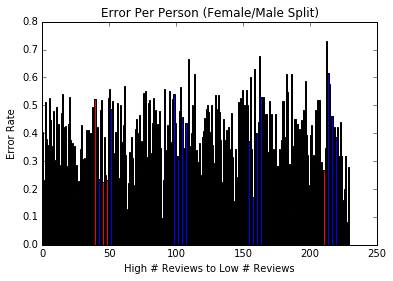

In [13]:
pred = list_of_x([],num_good_reviewers)
for i in range(num_good_reviewers):
    pred[i] = np.ones(len(test[i]))
    if (Counter(good_reviews[i][train[i]]).most_common(1)[0][0] == -1):
        pred[i] = -1*pred[i]
print(get_confusion_matrix(pred,test))
print(get_confusion_matrix_gender(pred,test,"m"))
print(get_confusion_matrix_gender(pred,test,"f"))
print("Error: %0.2f" % get_error(pred,test))
print("Female Error: %0.2f" % get_error_gender(pred,test, "f"))
print("Male Error: %0.2f" % get_error_gender(pred,test, "m"))
print("General Summary:")
summarize_conf_m(pred,test)
print("Male Summary:")
summarize_conf_m_gender(pred,test,"m")
print("Female Summary:")
summarize_conf_m_gender(pred,test,"f")
plotErrorByPerson(pred,test,"baseline")

# Lowering Dimension of IMDB Matrix

In [14]:
rel_features = ["num_critic_for_reviews", "duration", "director_facebook_likes", 
                "budget", "gross" , "cast_total_facebook_likes", "title_year",
               "action", "adventure", "fantasy", "sci_fi", "thriller", "romance",
               "animation", "comedy", "family", "musical", "mystery", "western",
               "drama", "history", "sport", "crime", "horror", "war", "biography",
               "music", "documentary", "aspect_ratio", "pg_13", "pg", "g", "r",
                "nc_17", "not_rated","unrated"]
X = np.zeros((num_movies, len(rel_features)))
for i in range(num_movies):
    for j in range(len(rel_features)):
        X[i,j] = good_movies.iloc[i][rel_features[j]]

In [15]:
# Normalizing matrix for PCA
X = normalize(X, norm='l2', axis=0)

We are retaining 0.75% of the Variance in X


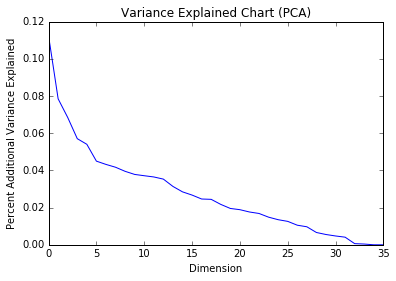

In [16]:
pca = PCA(n_components=len(rel_features))
pca.fit(X)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel("Dimension")
plt.ylabel("Percent Additional Variance Explained")
plt.title("Variance Explained Chart (PCA)")
pylab.savefig("pca_imdb.png")
n_c=15
pca = PCA(n_components=n_c)
pca.fit(X)
X_pca = pca.transform(X)
np.shape(pca.transform(X))
print("We are retaining %0.2f%% of the Variance in X" % sum(pca.explained_variance_ratio_[0:n_c]))

# Classification Row by Row

## Cluster Movies, Group Based on Most Common Label of Movies in that Cluster

### Clustering Movies

In [17]:
# to cluster movies we need to standardize
X_std = (X_pca - np.mean(X_pca, axis=0)) / np.std(X_pca, axis=0)

In [18]:
# 10-fold cross validation
cluster_size = range(2,31)
cv_error = np.zeros(len(cluster_size))

k_fold = KFold(n_splits=10)
for k in cluster_size:
    error = np.array([KMeans(n_clusters=k,random_state=0).fit(X_std[train_set]).inertia_
                      for train_set, test_set in k_fold.split(X_std)])
    cv_error[cluster_size.index(k)] = np.mean(error)

NameError: name 'KFold' is not defined

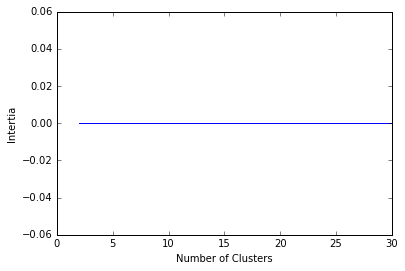

In [19]:
# plot to find number of clusters
plt.plot(cluster_size,cv_error)
plt.ylabel('Intertia')
plt.xlabel('Number of Clusters')
plt.show()

In [20]:
k = 15
kmeans = KMeans(n_clusters=k, random_state=0).fit(X_std)
movie_labels = kmeans.labels_

### Lets Test It

{'tn': 3029, 'fp': 2974, 'fn': 3216, 'tp': 5013}
{'tn': 1303, 'fp': 1142, 'fn': 1431, 'tp': 1752}
{'tn': 1726, 'fp': 1832, 'fn': 1785, 'tp': 3261}
Error: 0.43
Female Error: 0.42
Male Error: 0.46
General Summary:
True Positive Rate: 0.61
True Negative Rate: 0.50
Male Summary:
True Positive Rate: 0.55
True Negative Rate: 0.53
Female Summary:
True Positive Rate: 0.65
True Negative Rate: 0.49


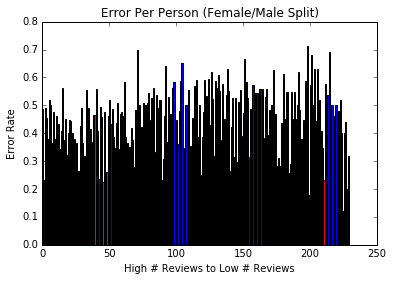

In [21]:
pred = list_of_x([],num_good_reviewers)
for i in range(num_good_reviewers):
    pred[i] = np.ones(len(test[i]))
    k_labels = np.zeros(k)
    for j in range(num_movies):
        if (j in train[i]):
            k_labels[movie_labels[j]]+=good_reviews[i][j]
    for j in range(len(test[i])):
        if (k_labels[movie_labels[test[i][j]]] > 0):
            pred[i][j]=1
        else:
            pred[i][j]=-1
print(get_confusion_matrix(pred,test))
print(get_confusion_matrix_gender(pred,test,"m"))
print(get_confusion_matrix_gender(pred,test,"f"))
print("Error: %0.2f" % get_error(pred,test))
print("Female Error: %0.2f" % get_error_gender(pred,test, "f"))
print("Male Error: %0.2f" % get_error_gender(pred,test, "m"))
print("General Summary:")
summarize_conf_m(pred,test)
print("Male Summary:")
summarize_conf_m_gender(pred,test,"m")
print("Female Summary:")
summarize_conf_m_gender(pred,test,"f")
plotErrorByPerson(pred,test,"kmeans1")

## Logistic Regression

{'tn': 2089, 'fp': 3914, 'fn': 1685, 'tp': 6544}
{'tn': 792, 'fp': 1653, 'fn': 614, 'tp': 2569}
{'tn': 1297, 'fp': 2261, 'fn': 1071, 'tp': 3975}
Error: 0.39
Female Error: 0.39
Male Error: 0.40
General Summary:
True Positive Rate: 0.80
True Negative Rate: 0.35
Male Summary:
True Positive Rate: 0.81
True Negative Rate: 0.32
Female Summary:
True Positive Rate: 0.79
True Negative Rate: 0.36


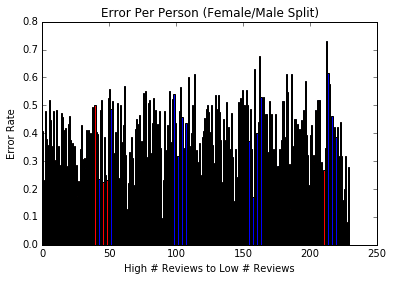

In [22]:
pred = list_of_x([],num_good_reviewers)
for i in range(num_good_reviewers):
    pred[i] = np.ones(len(test[i]))
    # train Logistic Regression
    X_train = X_pca[train[i],:]
    Y_train = good_reviews[i][train[i]]
    if (sum(Y_train) == len(Y_train)):
        pred[i] = np.ones(len(test[i]))
        if (Counter(good_reviews[i][train[i]]).most_common(1)[0][0] == -1):
            pred[i] = -1*pred[i]
    else:
        logistic = LogisticRegression()
        logistic.fit(X_train, Y_train)
        pred[i] = logistic.predict(X_pca[test[i],:])
print(get_confusion_matrix(pred,test))
print(get_confusion_matrix_gender(pred,test,"m"))
print(get_confusion_matrix_gender(pred,test,"f"))
print("Error: %0.2f" % get_error(pred,test))
print("Female Error: %0.2f" % get_error_gender(pred,test, "f"))
print("Male Error: %0.2f" % get_error_gender(pred,test, "m"))
print("General Summary:")
summarize_conf_m(pred,test)
print("Male Summary:")
summarize_conf_m_gender(pred,test,"m")
print("Female Summary:")
summarize_conf_m_gender(pred,test,"f")
plotErrorByPerson(pred,test,"logistic1")

## Random Forests and Trees

{'tn': 2848, 'fp': 3155, 'fn': 3282, 'tp': 4947}
{'tn': 1143, 'fp': 1302, 'fn': 1295, 'tp': 1888}
{'tn': 1705, 'fp': 1853, 'fn': 1987, 'tp': 3059}
Error: 0.45
Female Error: 0.45
Male Error: 0.46
General Summary:
True Positive Rate: 0.60
True Negative Rate: 0.47
Male Summary:
True Positive Rate: 0.59
True Negative Rate: 0.47
Female Summary:
True Positive Rate: 0.61
True Negative Rate: 0.48


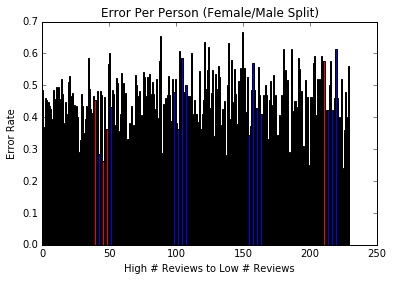

In [23]:
# trees

pred = list_of_x([],num_good_reviewers)
for i in range(num_good_reviewers):
    pred[i] = np.ones(len(test[i]))
    X_train = X_pca[train[i],:]
    Y_train = good_reviews[i][train[i]]
    clf = tree.DecisionTreeClassifier(random_state=0)
    clf.fit(X_train, Y_train)
    pred[i] = clf.predict(X_pca[test[i],:])
print(get_confusion_matrix(pred,test))
print(get_confusion_matrix_gender(pred,test,"m"))
print(get_confusion_matrix_gender(pred,test,"f"))
print("Error: %0.2f" % get_error(pred,test))
print("Female Error: %0.2f" % get_error_gender(pred,test, "f"))
print("Male Error: %0.2f" % get_error_gender(pred,test, "m"))
print("General Summary:")
summarize_conf_m(pred,test)
print("Male Summary:")
summarize_conf_m_gender(pred,test,"m")
print("Female Summary:")
summarize_conf_m_gender(pred,test,"f")
plotErrorByPerson(pred,test,"logistic1")

{'tn': 3156, 'fp': 2847, 'fn': 3407, 'tp': 4822}
{'tn': 1286, 'fp': 1159, 'fn': 1386, 'tp': 1797}
{'tn': 1870, 'fp': 1688, 'fn': 2021, 'tp': 3025}
Error: 0.44
Female Error: 0.43
Male Error: 0.45
General Summary:
True Positive Rate: 0.59
True Negative Rate: 0.53
Male Summary:
True Positive Rate: 0.56
True Negative Rate: 0.53
Female Summary:
True Positive Rate: 0.60
True Negative Rate: 0.53


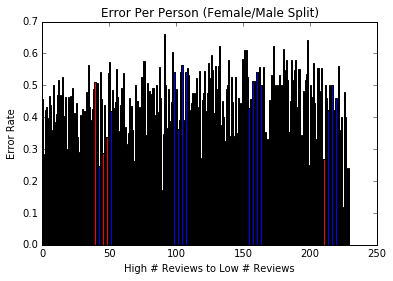

In [24]:
# random forest
pred = list_of_x([],num_good_reviewers)
for i in range(num_good_reviewers):
    pred[i] = np.ones(len(test[i]))
    X_train = X_pca[train[i],:]
    Y_train = good_reviews[i][train[i]]
    rf = RandomForestClassifier(random_state=0)
    rf.fit(X_train, Y_train)
    pred[i] = rf.predict(X_pca[test[i],:])
print(get_confusion_matrix(pred,test))
print(get_confusion_matrix_gender(pred,test,"m"))
print(get_confusion_matrix_gender(pred,test,"f"))
print("Error: %0.2f" % get_error(pred,test))
print("Female Error: %0.2f" % get_error_gender(pred,test, "f"))
print("Male Error: %0.2f" % get_error_gender(pred,test, "m"))
print("General Summary:")
summarize_conf_m(pred,test)
print("Male Summary:")
summarize_conf_m_gender(pred,test,"m")
print("Female Summary:")
summarize_conf_m_gender(pred,test,"f")
plotErrorByPerson(pred,test,"logistic1")

# Changing Reviews by Clustering Reviewers

### Spectral Clustering for Reviewers

In [25]:
def fit_kmeans(samples, num_components):
    k_means = KMeans(n_clusters=num_components)
    preds = k_means.fit_predict(samples)
    plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
    color1 = 'g'
    color2 = 'y'
    ax = plt.gca()
    color_dict = {idx:col for idx, col in enumerate(cm.rainbow(np.linspace(0, 1, num_components)))}
    colors = [color_dict[i] for i in preds]
    ax.scatter(samples[:,0], samples[:,1], 
               c=colors, alpha=0.8)
    return preds, color_dict

In [26]:
A = np.zeros((num_good_reviewers, num_good_reviewers))
t = 10 # TODO can try a few different values
for i in range(num_good_reviewers):
    for j in range(num_good_reviewers):
        dot = np.dot(good_reviews[i,:], good_reviews[j,:])
        if (dot >= t):
            A[i,j] = 1
        else:
            A[i,j] = 0

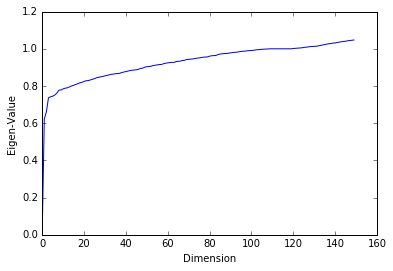

In [27]:
L_normed = csgraph.laplacian(A, normed=True)
eigenvalues_norm, eigenvectors_norm = np.linalg.eigh(L_normed)
plt.xlabel("Dimension")
plt.ylabel("Eigen-Value")
plt.plot(eigenvalues_norm[0:150])
plt.show()

In [28]:
# 10-fold cross validation
dim = 50
cluster_size = range(2,101)
cv_error = np.zeros(len(cluster_size))

for k in cluster_size:
    error = np.array([KMeans(n_clusters=k,random_state=0).fit(eigenvectors_norm[train_set,0:dim]).inertia_
                      for train_set, test_set in k_fold.split(eigenvectors_norm[:,0:dim])])
    cv_error[cluster_size.index(k)] = np.mean(error)

NameError: name 'k_fold' is not defined

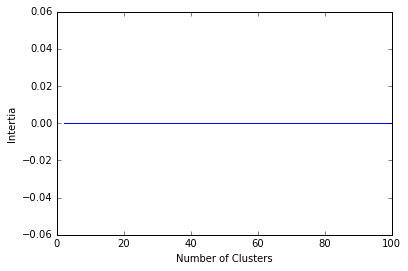

In [29]:
# plot to find number of clusters
plt.plot(cluster_size,cv_error)
plt.ylabel('Intertia')
plt.xlabel('Number of Clusters')
plt.show()

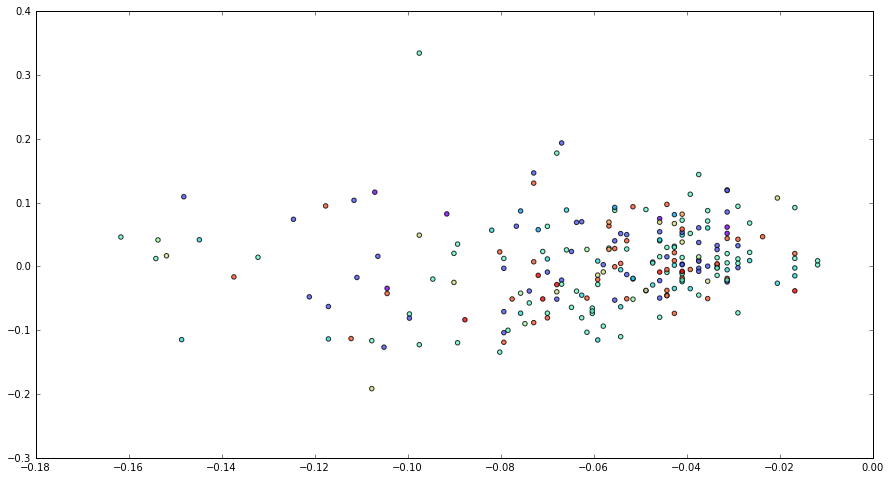

In [30]:
k = 10
dim=50
preds_kmeans, colors_kmeans = fit_kmeans(eigenvectors_norm[:,0:dim],k)

### Modify Reviews so that each person also has reviews of other points in cluster

* Creating matrix called good_reviews2
* Training will be done on good_reviews2
* good_reviews2 does not contain any testing data
* Instead, zero and testing data points are replaced by the most common score among other people in cluster
* All testing is done on the actual review matrix

In [31]:
good_reviews2 = np.zeros((num_good_reviewers, num_movies))
count_additions = 0
for i in range(num_good_reviewers):
    for j in train[i]:
        good_reviews2[i,j] = good_reviews[i,j] # keep old training data
    for j in range(len(test[i])):
        # add points to test data
        cluster = preds_kmeans[i] # cluster of i
        label_lst = [] # will take the most of the labels
        for k in range(num_good_reviewers): # for each other reviewer
            if (preds_kmeans[k]==cluster and (not k==i)): # if it is a different reviewer
                # same cluster 
                if test[i][j] in train[k]:
                    label_lst.append(good_reviews[k,test[i][j]])
        if len(label_lst)>0:
            good_reviews2[i,j] = Counter(label_lst).most_common(1)[0][0]
            count_additions+=1
print("This led to %d additions in our training set overall" % count_additions)

This led to 12210 additions in our training set overall


In [32]:
## train is a little different now
train2 = list_of_x([],num_good_reviewers)
for i in range(num_good_reviewers):
    for j in range(num_movies):
        if j in train[i]:
            train2[i].append(j)
        elif j not in train[i] and (not good_reviews2[i,j]==0):
            train2[i].append(j)

### Try Baseline 2.0

{'tn': 813, 'fp': 5190, 'fn': 516, 'tp': 7713}
{'tn': 469, 'fp': 1976, 'fn': 286, 'tp': 2897}
{'tn': 344, 'fp': 3214, 'fn': 230, 'tp': 4816}
Error: 0.40
Female Error: 0.40
Male Error: 0.40
General Summary:
True Positive Rate: 0.94
True Negative Rate: 0.14
Male Summary:
True Positive Rate: 0.91
True Negative Rate: 0.19
Female Summary:
True Positive Rate: 0.95
True Negative Rate: 0.10


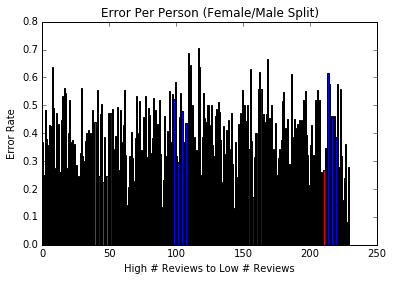

In [33]:
pred = list_of_x([],num_good_reviewers)
for i in range(num_good_reviewers):
    pred[i] = np.ones(len(test[i]))
    if (Counter(good_reviews2[i][train2[i]]).most_common(1)[0][0] == -1):
        pred[i] = -1*pred[i]
    for j in test[i]:
        if j in train2[i]:
            pred[i][j] = good_reviews2[i][j]
print(get_confusion_matrix(pred,test))
print(get_confusion_matrix_gender(pred,test,"m"))
print(get_confusion_matrix_gender(pred,test,"f"))
print("Error: %0.2f" % get_error(pred,test))
print("Female Error: %0.2f" % get_error_gender(pred,test, "f"))
print("Male Error: %0.2f" % get_error_gender(pred,test, "m"))
print("General Summary:")
summarize_conf_m(pred,test)
print("Male Summary:")
summarize_conf_m_gender(pred,test,"m")
print("Female Summary:")
summarize_conf_m_gender(pred,test,"f")
plotErrorByPerson(pred,test,"baseline")

### Try Clustering again

In [34]:
k = 50
kmeans = KMeans(n_clusters=k, random_state=0).fit(X_std)
movie_labels = kmeans.labels_

{'tn': 2801, 'fp': 3202, 'fn': 3332, 'tp': 4897}
{'tn': 1334, 'fp': 1111, 'fn': 1572, 'tp': 1611}
{'tn': 1467, 'fp': 2091, 'fn': 1760, 'tp': 3286}
Error: 0.46
Female Error: 0.45
Male Error: 0.48
General Summary:
True Positive Rate: 0.60
True Negative Rate: 0.47
Male Summary:
True Positive Rate: 0.51
True Negative Rate: 0.55
Female Summary:
True Positive Rate: 0.65
True Negative Rate: 0.41


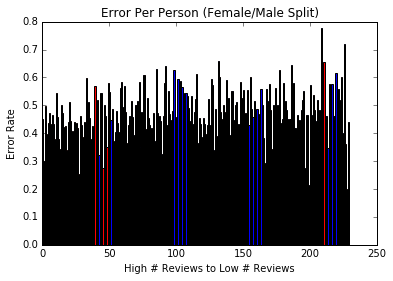

In [35]:
pred = list_of_x([],num_good_reviewers)
for i in range(num_good_reviewers):
    pred[i] = np.ones(len(test[i]))
    k_labels = np.zeros(k)
    for j in range(num_movies):
        if (j in train2[i]):
            k_labels[movie_labels[j]]+=good_reviews2[i][j]
    for j in range(len(test[i])):
        if (k_labels[movie_labels[test[i][j]]] > 0):
            pred[i][j]=1
        else:
            pred[i][j]=-1
print(get_confusion_matrix(pred,test))
print(get_confusion_matrix_gender(pred,test,"m"))
print(get_confusion_matrix_gender(pred,test,"f"))
print("Error: %0.2f" % get_error(pred,test))
print("Female Error: %0.2f" % get_error_gender(pred,test, "f"))
print("Male Error: %0.2f" % get_error_gender(pred,test, "m"))
print("General Summary:")
summarize_conf_m(pred,test)
print("Male Summary:")
summarize_conf_m_gender(pred,test,"m")
print("Female Summary:")
summarize_conf_m_gender(pred,test,"f")
plotErrorByPerson(pred,test,"kmeans1")

### Try Logistic Reg Aggain

{'tn': 538, 'fp': 5465, 'fn': 341, 'tp': 7888}
{'tn': 426, 'fp': 2019, 'fn': 256, 'tp': 2927}
{'tn': 112, 'fp': 3446, 'fn': 85, 'tp': 4961}
Error: 0.41
Female Error: 0.41
Male Error: 0.40
General Summary:
True Positive Rate: 0.96
True Negative Rate: 0.09
Male Summary:
True Positive Rate: 0.92
True Negative Rate: 0.17
Female Summary:
True Positive Rate: 0.98
True Negative Rate: 0.03


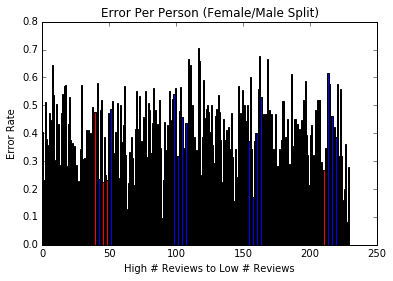

In [36]:
pred = list_of_x([],num_good_reviewers)
for i in range(num_good_reviewers):
    pred[i] = np.ones(len(test[i]))
    # train Logistic Regression
    X_train = X_pca[train2[i],:]
    Y_train = good_reviews2[i,train2[i]]
    if (sum(Y_train) == len(Y_train)):
        pred[i] = np.ones(len(test[i]))
        if (Counter(good_reviews2[i][train2[i]]).most_common(1)[0][0] == -1):
            pred[i] = -1*pred[i]
    else:
        logistic = LogisticRegression()
        logistic.fit(X_train, Y_train)
        pred[i] = logistic.predict(X_pca[test[i],:])
print(get_confusion_matrix(pred,test))
print(get_confusion_matrix_gender(pred,test,"m"))
print(get_confusion_matrix_gender(pred,test,"f"))
print("Error: %0.2f" % get_error(pred,test))
print("Female Error: %0.2f" % get_error_gender(pred,test, "f"))
print("Male Error: %0.2f" % get_error_gender(pred,test, "m"))
print("General Summary:")
summarize_conf_m(pred,test)
print("Male Summary:")
summarize_conf_m_gender(pred,test,"m")
print("Female Summary:")
summarize_conf_m_gender(pred,test,"f")
plotErrorByPerson(pred,test,"logistic1")

### Trees

{'tn': 2480, 'fp': 3523, 'fn': 3046, 'tp': 5183}
{'tn': 1004, 'fp': 1441, 'fn': 1211, 'tp': 1972}
{'tn': 1476, 'fp': 2082, 'fn': 1835, 'tp': 3211}
Error: 0.46
Female Error: 0.46
Male Error: 0.47
General Summary:
True Positive Rate: 0.63
True Negative Rate: 0.41
Male Summary:
True Positive Rate: 0.62
True Negative Rate: 0.41
Female Summary:
True Positive Rate: 0.64
True Negative Rate: 0.41


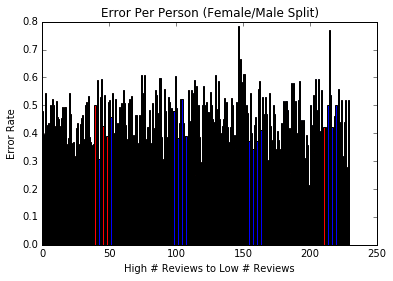

In [37]:
# trees

pred = list_of_x([],num_good_reviewers)
for i in range(num_good_reviewers):
    pred[i] = np.ones(len(test[i]))
    X_train = X_pca[train2[i],:]
    Y_train = good_reviews2[i][train2[i]]
    clf = tree.DecisionTreeClassifier(random_state=0)
    clf.fit(X_train, Y_train)
    pred[i] = clf.predict(X_pca[test[i],:])
print(get_confusion_matrix(pred,test))
print(get_confusion_matrix_gender(pred,test,"m"))
print(get_confusion_matrix_gender(pred,test,"f"))
print("Error: %0.2f" % get_error(pred,test))
print("Female Error: %0.2f" % get_error_gender(pred,test, "f"))
print("Male Error: %0.2f" % get_error_gender(pred,test, "m"))
print("General Summary:")
summarize_conf_m(pred,test)
print("Male Summary:")
summarize_conf_m_gender(pred,test,"m")
print("Female Summary:")
summarize_conf_m_gender(pred,test,"f")
plotErrorByPerson(pred,test,"logistic1")

{'tn': 2521, 'fp': 3482, 'fn': 2930, 'tp': 5299}
{'tn': 1098, 'fp': 1347, 'fn': 1203, 'tp': 1980}
{'tn': 1423, 'fp': 2135, 'fn': 1727, 'tp': 3319}
Error: 0.45
Female Error: 0.45
Male Error: 0.45
General Summary:
True Positive Rate: 0.64
True Negative Rate: 0.42
Male Summary:
True Positive Rate: 0.62
True Negative Rate: 0.45
Female Summary:
True Positive Rate: 0.66
True Negative Rate: 0.40


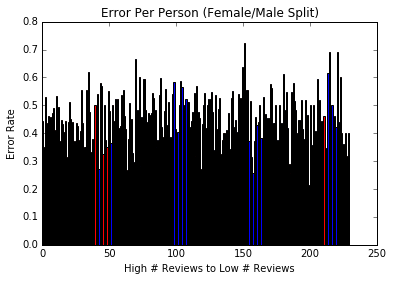

In [38]:
# random forest
pred = list_of_x([],num_good_reviewers)
for i in range(num_good_reviewers):
    pred[i] = np.ones(len(test[i]))
    X_train = X_pca[train2[i],:]
    Y_train = good_reviews2[i][train2[i]]
    rf = RandomForestClassifier(random_state=0)
    rf.fit(X_train, Y_train)
    pred[i] = rf.predict(X_pca[test[i],:])
print(get_confusion_matrix(pred,test))
print(get_confusion_matrix_gender(pred,test,"m"))
print(get_confusion_matrix_gender(pred,test,"f"))
print("Error: %0.2f" % get_error(pred,test))
print("Female Error: %0.2f" % get_error_gender(pred,test, "f"))
print("Male Error: %0.2f" % get_error_gender(pred,test, "m"))
print("General Summary:")
summarize_conf_m(pred,test)
print("Male Summary:")
summarize_conf_m_gender(pred,test,"m")
print("Female Summary:")
summarize_conf_m_gender(pred,test,"f")
plotErrorByPerson(pred,test,"logistic1")

# Baseline 3.0

{'tn': 3243, 'fp': 2760, 'fn': 1910, 'tp': 6319}
{'tn': 1380, 'fp': 1065, 'fn': 768, 'tp': 2415}
{'tn': 1863, 'fp': 1695, 'fn': 1142, 'tp': 3904}
Error: 0.33
Female Error: 0.33
Male Error: 0.33
General Summary:
True Positive Rate: 0.77
True Negative Rate: 0.54
Male Summary:
True Positive Rate: 0.76
True Negative Rate: 0.56
Female Summary:
True Positive Rate: 0.77
True Negative Rate: 0.52


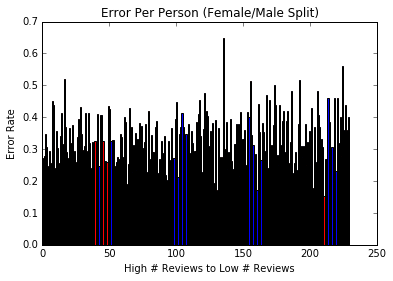

In [39]:
## Check if movie reviews are just a function of other people's reviews
pred = list_of_x([],num_good_reviewers)
for i in range(num_good_reviewers):
    pred[i] = np.ones(len(test[i]))
    for j in range(len(test[i])):
        other_reviews = []
        for k in range(num_good_reviewers):
            if test[i][j] in train[k]:
                other_reviews.append(good_reviews[k,test[i][j]])
        if (len(other_reviews)>0):
            pred[i][j] = Counter(other_reviews).most_common(1)[0][0]
print(get_confusion_matrix(pred,test))
print(get_confusion_matrix_gender(pred,test,"m"))
print(get_confusion_matrix_gender(pred,test,"f"))
print("Error: %0.2f" % get_error(pred,test))
print("Female Error: %0.2f" % get_error_gender(pred,test, "f"))
print("Male Error: %0.2f" % get_error_gender(pred,test, "m"))
print("General Summary:")
summarize_conf_m(pred,test)
print("Male Summary:")
summarize_conf_m_gender(pred,test,"m")
print("Female Summary:")
summarize_conf_m_gender(pred,test,"f")
plotErrorByPerson(pred,test,"baseline")